In [1]:
import numpy as np
import pandas as pd
import sklearn
from sklearn.model_selection import train_test_split
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestClassifier
%matplotlib inline

from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.compose import make_column_transformer
from sklearn.pipeline import make_pipeline
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV,StratifiedKFold
from xgboost import XGBClassifier
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import random
from sklearn.svm import SVC

In [2]:
df = pd.read_csv('data/features_3_sec.csv') 
df = df.set_index('filename')
# map labels to index
label_index = dict()
index_label = dict()
for i, x in enumerate(df.label.unique()):
    label_index[x] = i 
    index_label[i] = x
# update labels in df to index
df.label = [label_index[l] for l in df.label]
# length is not an informative feature so we just drop it
X = df.drop(columns=['label', 'length']) 
y = df['label']

In [3]:
X_dev, X_test, y_dev, y_test = train_test_split(X, y, test_size=0.2)

preprocess = make_column_transformer((StandardScaler(), X_dev.columns))
pipe = make_pipeline(preprocess)

pipe.fit(X_dev)
X_dev = pipe.transform(X_dev)
X_test = pipe.transform(X_test)

X_train, X_val, y_train, y_val = train_test_split(X_dev, y_dev, test_size=0.2)

# HistGradientBoosting

In [4]:
hgb_param_grid = {"max_iter": [100, 200, 300],
                  "learning_rate": np.random.uniform(0.01, 0.3, 3),
                  "max_depth": [4, 6, 8]}
hgb_param_grid

{'max_iter': [100, 200, 300],
 'learning_rate': array([0.01392729, 0.23011298, 0.01988799]),
 'max_depth': [4, 6, 8]}

In [5]:
grid_search = GridSearchCV(HistGradientBoostingClassifier(random_state=0), 
                           param_grid = hgb_param_grid, 
                           cv = 5,
                           n_jobs=-1)
grid_search.fit(X_train, y_train)
print("Best parameter set is: {}".format(grid_search.best_params_))
best_hgb = grid_search.best_estimator_
best_hgb.fit(X_train, y_train)

print('\nClassification Report of tuned HGB on validation set')
print(classification_report(y_val, best_hgb.predict(X_val)))

Best parameter set is: {'learning_rate': 0.23011297923297772, 'max_depth': 6, 'max_iter': 300}

Classification Report of tuned HGB on validation set
              precision    recall  f1-score   support

           0       0.92      0.88      0.90       162
           1       0.96      0.96      0.96       188
           2       0.84      0.89      0.86       131
           3       0.94      0.91      0.93       177
           4       0.91      0.88      0.90       136
           5       0.89      0.93      0.91       167
           6       0.90      0.94      0.92       138
           7       0.93      0.92      0.92       168
           8       0.92      0.91      0.91       179
           9       0.85      0.84      0.85       153

    accuracy                           0.91      1599
   macro avg       0.91      0.91      0.91      1599
weighted avg       0.91      0.91      0.91      1599



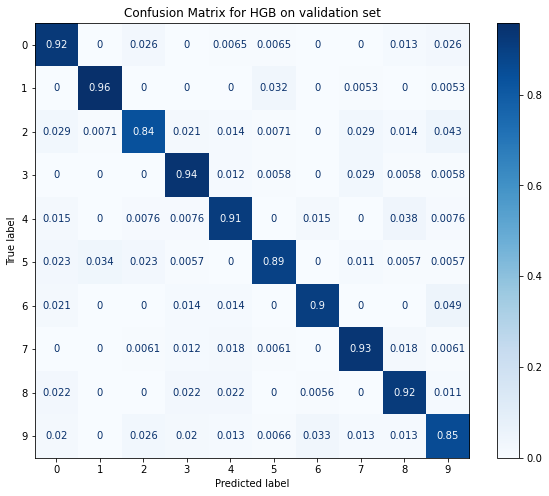

In [6]:
class_labels = list(best_hgb.classes_)
yhat = best_hgb.predict(X_val)

cm = confusion_matrix(list(yhat), list(y_val), normalize='true')
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels = class_labels);

fig,ax = plt.subplots(1,figsize=(10,8))
disp.plot(ax=ax, cmap=plt.cm.Blues);
plt.title('Confusion Matrix for HGB on validation set');

# GradientBoosting

In [7]:
gb_param_grid = {"n_estimators": [100],
                 "learning_rate": [0.1],
                 "max_depth": random.sample(range(3, 8), 2)}
gb_param_grid

{'n_estimators': [100], 'learning_rate': [0.1], 'max_depth': [4, 3]}

In [8]:
%%time
grid_search = GridSearchCV(GradientBoostingClassifier(random_state=0), 
                           param_grid=gb_param_grid, 
                           cv=3,
                           n_jobs=-1)
grid_search.fit(X_train, y_train)
print("Best parameter set is: {}".format(grid_search.best_params_))
best_gb = grid_search.best_estimator_
best_gb.fit(X_train, y_train)

print('\nClassification Report of tuned GB on validation set')
print(classification_report(y_val, best_gb.predict(X_val)))

Best parameter set is: {'learning_rate': 0.1, 'max_depth': 4, 'n_estimators': 100}

Classification Report of tuned GB on validation set
              precision    recall  f1-score   support

           0       0.85      0.79      0.82       162
           1       0.95      0.93      0.94       188
           2       0.71      0.82      0.76       131
           3       0.87      0.86      0.86       177
           4       0.88      0.85      0.86       136
           5       0.81      0.91      0.86       167
           6       0.85      0.90      0.87       138
           7       0.93      0.85      0.89       168
           8       0.84      0.86      0.85       179
           9       0.82      0.73      0.78       153

    accuracy                           0.85      1599
   macro avg       0.85      0.85      0.85      1599
weighted avg       0.85      0.85      0.85      1599

CPU times: user 3min 25s, sys: 263 ms, total: 3min 25s
Wall time: 4min 42s


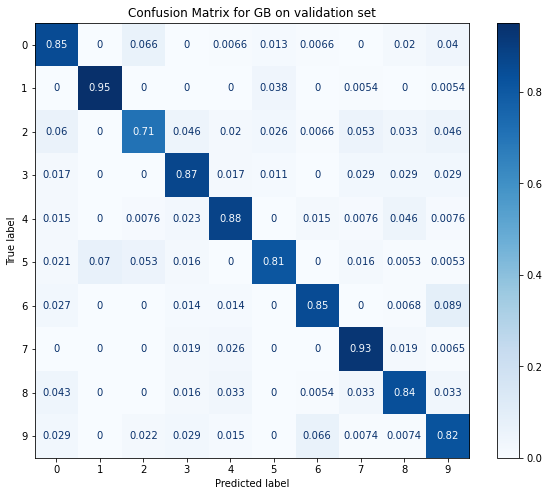

In [9]:
yhat = best_gb.predict(X_val)

cm = confusion_matrix(list(yhat), list(y_val), normalize='true')
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels = class_labels);

fig,ax = plt.subplots(1,figsize=(10,8))
disp.plot(ax=ax, cmap=plt.cm.Blues);
plt.title('Confusion Matrix for GB on validation set');

# XGB

In [10]:
xgb_param_grid={"n_estimators": [100],
            "learning_rate": [0.1],
            "max_depth": random.sample(range(3, 8), 2),
            'eval_metric':['logloss'],
            "use_label_encoder": [False]}
xgb_param_grid


{'n_estimators': [100],
 'learning_rate': [0.1],
 'max_depth': [3, 6],
 'eval_metric': ['logloss'],
 'use_label_encoder': [False]}

In [11]:
%%time
grid_search = GridSearchCV(XGBClassifier(random_state=0), 
                           param_grid=xgb_param_grid, 
                           cv=3,
                           n_jobs=-1)
grid_search.fit(X_train, y_train)
print("Best parameter set is: {}".format(grid_search.best_params_))
best_xgb = grid_search.best_estimator_
best_xgb.fit(X_train, y_train)

print('\nClassification Report of tuned XGB on validation set')
print(classification_report(y_val, best_xgb.predict(X_val)))

Best parameter set is: {'eval_metric': 'logloss', 'learning_rate': 0.1, 'max_depth': 6, 'n_estimators': 100, 'use_label_encoder': False}

Classification Report of tuned XGB on validation set
              precision    recall  f1-score   support

           0       0.85      0.80      0.82       162
           1       0.96      0.94      0.95       188
           2       0.74      0.83      0.78       131
           3       0.85      0.85      0.85       177
           4       0.90      0.85      0.88       136
           5       0.86      0.90      0.88       167
           6       0.85      0.89      0.87       138
           7       0.92      0.87      0.89       168
           8       0.87      0.85      0.86       179
           9       0.75      0.77      0.76       153

    accuracy                           0.86      1599
   macro avg       0.86      0.86      0.85      1599
weighted avg       0.86      0.86      0.86      1599

CPU times: user 4min 45s, sys: 2.33 s, total: 4min

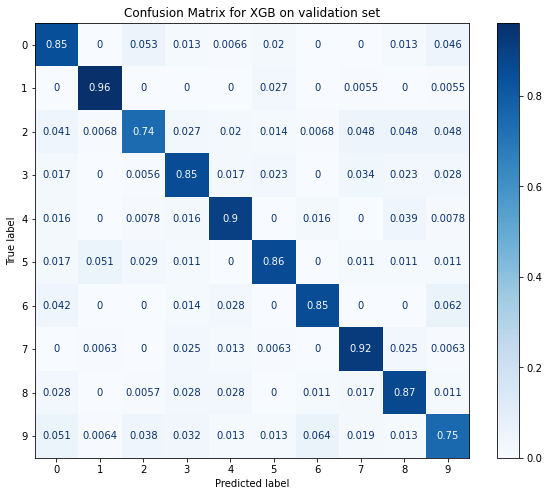

In [12]:
yhat = best_xgb.predict(X_val)

cm = confusion_matrix(list(yhat), list(y_val), normalize='true')
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels = class_labels);

fig,ax = plt.subplots(1,figsize=(10,8))
disp.plot(ax=ax, cmap=plt.cm.Blues);
plt.title('Confusion Matrix for XGB on validation set');

# SVM

In [13]:
svm_param_grid={"kernel": ['linear', 'rbf', 'sigmoid'],
            "C": [0.001, 0.01, 0.1, 1, 10],
            "gamma": [0.001, 0.01, 0.1, 1]}
svm_param_grid

{'kernel': ['linear', 'rbf', 'sigmoid'],
 'C': [0.001, 0.01, 0.1, 1, 10],
 'gamma': [0.001, 0.01, 0.1, 1]}

In [14]:
%%time
grid_search = GridSearchCV(SVC(random_state=0), 
                           param_grid=svm_param_grid, 
                           cv=3,
                           n_jobs=-1)
grid_search.fit(X_train, y_train)
print("Best parameter set is: {}".format(grid_search.best_params_))
best_SVM = grid_search.best_estimator_
best_SVM.fit(X_train, y_train)

print('\nClassification Report of tuned XGB on validation set')
print(classification_report(y_val, best_SVM.predict(X_val)))

Best parameter set is: {'C': 10, 'gamma': 0.01, 'kernel': 'rbf'}

Classification Report of tuned XGB on validation set
              precision    recall  f1-score   support

           0       0.91      0.89      0.90       162
           1       0.96      0.95      0.95       188
           2       0.80      0.87      0.83       131
           3       0.89      0.87      0.88       177
           4       0.89      0.92      0.91       136
           5       0.90      0.92      0.91       167
           6       0.91      0.95      0.93       138
           7       0.93      0.90      0.92       168
           8       0.94      0.89      0.91       179
           9       0.81      0.80      0.81       153

    accuracy                           0.90      1599
   macro avg       0.89      0.90      0.89      1599
weighted avg       0.90      0.90      0.90      1599

CPU times: user 4.38 s, sys: 188 ms, total: 4.57 s
Wall time: 1min 20s


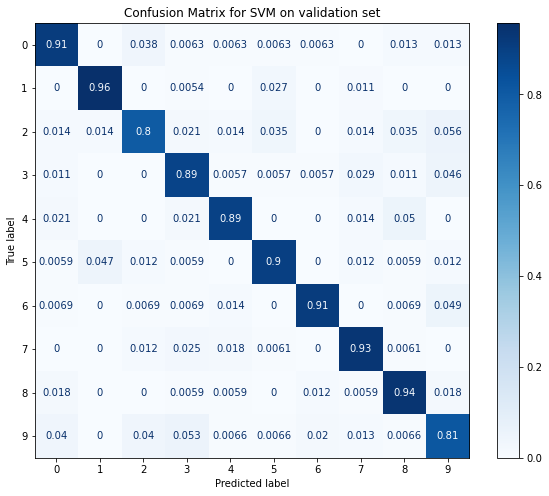

In [15]:
yhat = best_SVM.predict(X_val)

cm = confusion_matrix(list(yhat), list(y_val), normalize='true')
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels = class_labels);

fig,ax = plt.subplots(1,figsize=(10,8))
disp.plot(ax=ax, cmap=plt.cm.Blues);
plt.title('Confusion Matrix for SVM on validation set');

# Neural Network

In [16]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation,Dense,Dropout,Flatten
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import MaxPooling2D, Conv2D

In [17]:
df = pd.read_csv('data/features_3_sec.csv')
df = df.set_index('filename')

# map labels to index
label_index = dict()
index_label = dict()
for i, x in enumerate(df.label.unique()):
    label_index[x] = i
    index_label[i] = x

# update labels in df to index
df.label = [label_index[l] for l in df.label]
# length is not an informative feature so we just drop it
X = df.drop(columns=['label', 'length'])
y = df['label']
X_dev, X_test, y_dev, y_test = train_test_split(X, y, test_size=0.2)

preprocess = make_column_transformer((StandardScaler(), X_dev.columns))
pipe = make_pipeline(preprocess)

pipe.fit(X_dev)
X_dev = pipe.transform(X_dev)
X_test = pipe.transform(X_test)

y_dev = np.array(y_dev)
y_test = np.array(y_test)
X_train, X_val, y_train, y_val = train_test_split(X_dev, y_dev, test_size=0.2, random_state=0)

In [18]:
def trainModel(model, epochs, optimizer):
    batch_size = 128
    model.compile(optimizer=optimizer,
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy']
    )
    return model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=epochs, batch_size=batch_size)

In [19]:
def plotHistory(hist):
    print("Max training accuracy =", max(hist.history["accuracy"]))
    print("Max validation accuracy =", max(hist.history["val_accuracy"]))
    print("Max training loss =", max(hist.history["loss"]))
    print("Max validation accuracy =", max(hist.history["val_loss"]))
    result_df = pd.DataFrame(hist_nn1.history).rename(columns={'loss':'train_loss', 'accuracy': 'train_accuracy'})
    result_df.plot(figsize=(10,6))
    plt.legend(loc='lower right');
    plt.title('Model Accuracy and Model Loss')
    plt.show()

## First fully connected NN model

In [20]:
nn1 = Sequential()
nn1.add(Dense(512, activation='relu', input_shape=(X_train.shape[1],)))
nn1.add(Dense(256, activation='relu'))
nn1.add(Dense(128, activation='relu'))
nn1.add(Dense(64, activation='relu'))
nn1.add(Dense(10, activation='softmax'))
print(nn1.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 512)               29696     
_________________________________________________________________
dense_1 (Dense)              (None, 256)               131328    
_________________________________________________________________
dense_2 (Dense)              (None, 128)               32896     
_________________________________________________________________
dense_3 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_4 (Dense)              (None, 10)                650       
Total params: 202,826
Trainable params: 202,826
Non-trainable params: 0
_________________________________________________________________
None


2022-04-22 02:13:16.306637: I tensorflow/core/platform/cpu_feature_guard.cc:145] This TensorFlow binary is optimized with Intel(R) MKL-DNN to use the following CPU instructions in performance critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in non-MKL-DNN operations, rebuild TensorFlow with the appropriate compiler flags.
2022-04-22 02:13:16.307109: I tensorflow/core/common_runtime/process_util.cc:115] Creating new thread pool with default inter op setting: 12. Tune using inter_op_parallelism_threads for best performance.


In [21]:
hist_nn1 = trainModel(model=nn1, epochs=200, optimizer='adam')

Train on 6393 samples, validate on 1599 samples
Epoch 1/200
6393/6393 [==============================] - 1s 219us/sample - loss: 1.3314 - accuracy: 0.5461 - val_loss: 0.9376 - val_accuracy: 0.6635
Epoch 2/200
6393/6393 [==============================] - 0s 63us/sample - loss: 0.7845 - accuracy: 0.7260 - val_loss: 0.7431 - val_accuracy: 0.7436
Epoch 3/200
6393/6393 [==============================] - 0s 62us/sample - loss: 0.5890 - accuracy: 0.7960 - val_loss: 0.6150 - val_accuracy: 0.7949
Epoch 4/200
6393/6393 [==============================] - 0s 64us/sample - loss: 0.4671 - accuracy: 0.8431 - val_loss: 0.5614 - val_accuracy: 0.8074
Epoch 5/200
6393/6393 [==============================] - 0s 62us/sample - loss: 0.3670 - accuracy: 0.8802 - val_loss: 0.5103 - val_accuracy: 0.8299
Epoch 6/200
6393/6393 [==============================] - 0s 64us/sample - loss: 0.2798 - accuracy: 0.9141 - val_loss: 0.4791 - val_accuracy: 0.8430
Epoch 7/200
6393/6393 [==============================] - 0s 64u

Epoch 56/200
6393/6393 [==============================] - 0s 59us/sample - loss: 0.0047 - accuracy: 0.9983 - val_loss: 0.5323 - val_accuracy: 0.9043
Epoch 57/200
6393/6393 [==============================] - 0s 60us/sample - loss: 0.0067 - accuracy: 0.9980 - val_loss: 0.5546 - val_accuracy: 0.8981
Epoch 58/200
6393/6393 [==============================] - 0s 60us/sample - loss: 0.0033 - accuracy: 0.9991 - val_loss: 0.5488 - val_accuracy: 0.8993
Epoch 59/200
6393/6393 [==============================] - 0s 60us/sample - loss: 0.0016 - accuracy: 0.9992 - val_loss: 0.5392 - val_accuracy: 0.9006
Epoch 60/200
6393/6393 [==============================] - 0s 65us/sample - loss: 0.0015 - accuracy: 0.9992 - val_loss: 0.5463 - val_accuracy: 0.8981
Epoch 61/200
6393/6393 [==============================] - 0s 62us/sample - loss: 0.0012 - accuracy: 0.9995 - val_loss: 0.5392 - val_accuracy: 0.9006
Epoch 62/200
6393/6393 [==============================] - 0s 61us/sample - loss: 0.0017 - accuracy: 0.9994

6393/6393 [==============================] - 0s 65us/sample - loss: 0.0010 - accuracy: 0.9992 - val_loss: 0.5920 - val_accuracy: 0.9049
Epoch 111/200
6393/6393 [==============================] - 0s 62us/sample - loss: 9.9225e-04 - accuracy: 0.9995 - val_loss: 0.5877 - val_accuracy: 0.9037
Epoch 112/200
6393/6393 [==============================] - 0s 64us/sample - loss: 9.6327e-04 - accuracy: 0.9994 - val_loss: 0.5899 - val_accuracy: 0.9043
Epoch 113/200
6393/6393 [==============================] - 0s 65us/sample - loss: 0.0011 - accuracy: 0.9992 - val_loss: 0.5863 - val_accuracy: 0.9056
Epoch 114/200
6393/6393 [==============================] - 0s 65us/sample - loss: 9.3370e-04 - accuracy: 0.9992 - val_loss: 0.5959 - val_accuracy: 0.9056
Epoch 115/200
6393/6393 [==============================] - 0s 70us/sample - loss: 9.4415e-04 - accuracy: 0.9994 - val_loss: 0.6041 - val_accuracy: 0.8993
Epoch 116/200
6393/6393 [==============================] - 0s 67us/sample - loss: 8.0203e-04 - acc

Epoch 164/200
6393/6393 [==============================] - 0s 62us/sample - loss: 0.0011 - accuracy: 0.9994 - val_loss: 0.5759 - val_accuracy: 0.9068
Epoch 165/200
6393/6393 [==============================] - 0s 62us/sample - loss: 9.8015e-04 - accuracy: 0.9992 - val_loss: 0.5792 - val_accuracy: 0.9056
Epoch 166/200
6393/6393 [==============================] - 0s 61us/sample - loss: 0.0011 - accuracy: 0.9992 - val_loss: 0.5898 - val_accuracy: 0.9081
Epoch 167/200
6393/6393 [==============================] - 0s 62us/sample - loss: 9.0214e-04 - accuracy: 0.9995 - val_loss: 0.5969 - val_accuracy: 0.9093
Epoch 168/200
6393/6393 [==============================] - 0s 64us/sample - loss: 9.6454e-04 - accuracy: 0.9991 - val_loss: 0.5890 - val_accuracy: 0.9093
Epoch 169/200
6393/6393 [==============================] - 0s 65us/sample - loss: 9.2637e-04 - accuracy: 0.9994 - val_loss: 0.6165 - val_accuracy: 0.9056
Epoch 170/200
6393/6393 [==============================] - 0s 65us/sample - loss: 0.

Max training accuracy = 0.99968714
Max validation accuracy = 0.9099437
Max training loss = 1.331396927077241
Max validation accuracy = 0.9667094684601426


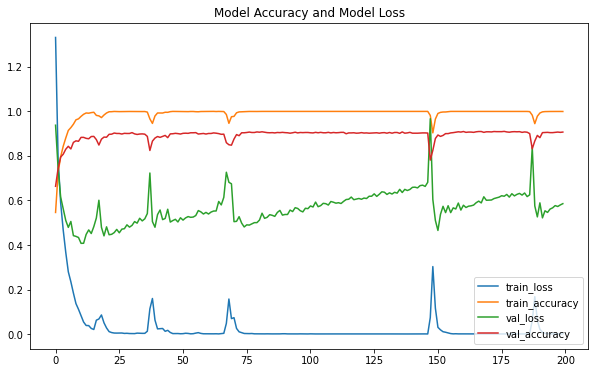

In [22]:
plotHistory(hist_nn1)

## Second fully connected NN model with Dropout

In [23]:
nn2 = Sequential()
nn2.add(Dense(512, activation='relu', input_shape=(X_train.shape[1],)))
nn2.add(Dropout(0.3))
nn2.add(Dense(256, activation='relu'))
nn2.add(Dropout(0.3))
nn2.add(Dense(128, activation='relu'))
nn2.add(Dropout(0.3))
nn2.add(Dense(64, activation='relu'))
nn2.add(Dropout(0.3))
nn2.add(Dense(10, activation='softmax'))

print(nn2.summary())
hist_nn2 = trainModel(model=nn2, epochs=200, optimizer='adam')

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_5 (Dense)              (None, 512)               29696     
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 256)               131328    
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_7 (Dense)              (None, 128)               32896     
_________________________________________________________________
dropout_2 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_8 (Dense)              (None, 64)               

6393/6393 [==============================] - 1s 120us/sample - loss: 0.1368 - accuracy: 0.9557 - val_loss: 0.3552 - val_accuracy: 0.9124
Epoch 46/200
6393/6393 [==============================] - 1s 120us/sample - loss: 0.1464 - accuracy: 0.9565 - val_loss: 0.3328 - val_accuracy: 0.9093
Epoch 47/200
6393/6393 [==============================] - 1s 121us/sample - loss: 0.1380 - accuracy: 0.9582 - val_loss: 0.3367 - val_accuracy: 0.9174
Epoch 48/200
6393/6393 [==============================] - 1s 121us/sample - loss: 0.1106 - accuracy: 0.9667 - val_loss: 0.3609 - val_accuracy: 0.9149
Epoch 49/200
6393/6393 [==============================] - 1s 122us/sample - loss: 0.1275 - accuracy: 0.9600 - val_loss: 0.3449 - val_accuracy: 0.9181
Epoch 50/200
6393/6393 [==============================] - 1s 121us/sample - loss: 0.1306 - accuracy: 0.9582 - val_loss: 0.3187 - val_accuracy: 0.9174
Epoch 51/200
6393/6393 [==============================] - 1s 119us/sample - loss: 0.1223 - accuracy: 0.9626 - val

Epoch 100/200
6393/6393 [==============================] - 1s 129us/sample - loss: 0.0578 - accuracy: 0.9823 - val_loss: 0.4530 - val_accuracy: 0.9106
Epoch 101/200
6393/6393 [==============================] - 1s 124us/sample - loss: 0.0635 - accuracy: 0.9797 - val_loss: 0.3951 - val_accuracy: 0.9174
Epoch 102/200
6393/6393 [==============================] - 1s 118us/sample - loss: 0.0703 - accuracy: 0.9797 - val_loss: 0.4064 - val_accuracy: 0.9237
Epoch 103/200
6393/6393 [==============================] - 1s 133us/sample - loss: 0.0746 - accuracy: 0.9790 - val_loss: 0.3905 - val_accuracy: 0.9181
Epoch 104/200
6393/6393 [==============================] - 1s 131us/sample - loss: 0.0582 - accuracy: 0.9815 - val_loss: 0.3896 - val_accuracy: 0.9193
Epoch 105/200
6393/6393 [==============================] - 1s 128us/sample - loss: 0.0733 - accuracy: 0.9781 - val_loss: 0.4002 - val_accuracy: 0.9168
Epoch 106/200
6393/6393 [==============================] - 1s 118us/sample - loss: 0.0757 - ac

6393/6393 [==============================] - 1s 117us/sample - loss: 0.0366 - accuracy: 0.9894 - val_loss: 0.4089 - val_accuracy: 0.9225
Epoch 155/200
6393/6393 [==============================] - 1s 117us/sample - loss: 0.0375 - accuracy: 0.9875 - val_loss: 0.3881 - val_accuracy: 0.9231
Epoch 156/200
6393/6393 [==============================] - 1s 117us/sample - loss: 0.0387 - accuracy: 0.9870 - val_loss: 0.3982 - val_accuracy: 0.9256
Epoch 157/200
6393/6393 [==============================] - 1s 118us/sample - loss: 0.0576 - accuracy: 0.9853 - val_loss: 0.3619 - val_accuracy: 0.9243
Epoch 158/200
6393/6393 [==============================] - 1s 117us/sample - loss: 0.0636 - accuracy: 0.9817 - val_loss: 0.3703 - val_accuracy: 0.9193
Epoch 159/200
6393/6393 [==============================] - 1s 117us/sample - loss: 0.0411 - accuracy: 0.9872 - val_loss: 0.3705 - val_accuracy: 0.9218
Epoch 160/200
6393/6393 [==============================] - 1s 117us/sample - loss: 0.0477 - accuracy: 0.9842

Max training accuracy = 0.99139684
Max validation accuracy = 0.934334
Max training loss = 1.8687783469434787
Max validation accuracy = 1.3466437122387913


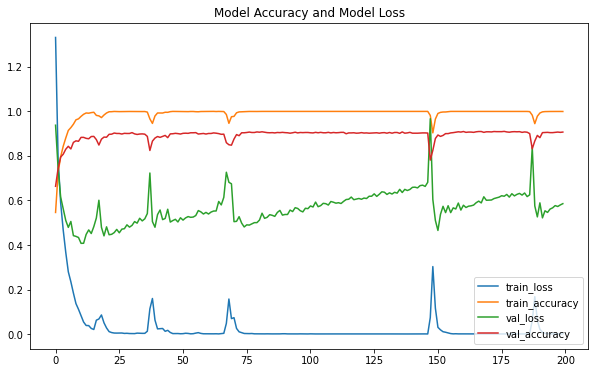

In [24]:
plotHistory(hist_nn2)

Dropout technique improves the model

### Taking into account of the running time and the `accuracy` and `macro-f1` on validation set, we would like to pick HistGradientBoosting from GB, XGB, HistGB and SVM. However, the fully connected NN model with dropout technique applied performs the best on validation set. So we pick the NN model . Lets see its performance on test set.

In [26]:
# NN with dropout model performance on test set
test_result = nn2.evaluate(X_test, y_test, verbose=0)
print("Test loss =", test_result[0])
print("Test accuracy =", test_result[1])

Test loss = 0.38356652700373
Test accuracy = 0.9239239


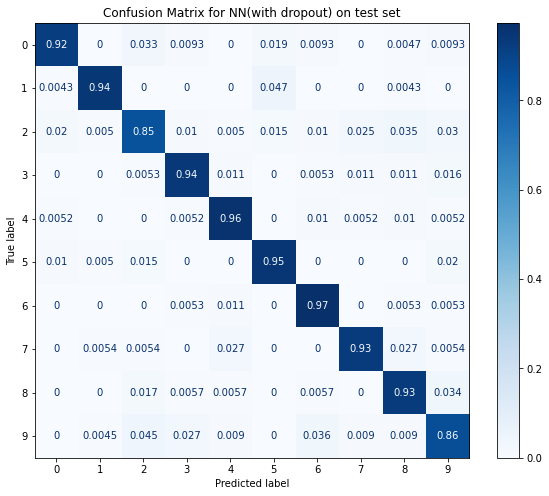

In [27]:
yhat = nn2.predict(X_test)
pred_labels = tf.math.argmax(yhat, axis=1)

cm = confusion_matrix(list(pred_labels), y_test, normalize='true')
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_labels);

fig,ax = plt.subplots(1,figsize=(10,8))
disp.plot(ax=ax, cmap=plt.cm.Blues);
plt.title('Confusion Matrix for NN(with dropout) on test set');

### Achieved 0.9289289 on test set :)